# Load combined data csv file

In [1]:
# pip install numpy==1.19.5  <-- needed numpy 1.19.5 to run LSTM function

In [2]:
# import all necessary libraries
import requests
import json
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
print(np.__version__)

1.19.5


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [5]:
# import FB Prophet libraries
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [6]:
# import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [7]:
# import LSTM libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [8]:
# this is not necessary but helps to run notebook faster
%config Completer.use_jedi = False

In [9]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [10]:
#Clear warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Set styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

In [12]:
pd.set_option("display.max_columns", 50)

In [13]:
combined = pd.read_csv('data/combined.csv')

In [14]:
# drop column 'Unnamed: 0'
combined.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
combined.shape

(26665, 28)

In [16]:
# change column 'Sale Date' to datetime
combined['sale_date'] = pd.to_datetime(combined['sale_date'], infer_datetime_format=True)

In [17]:
combined.columns

Index(['sale_date', 'item_name', 'quantity', 'transaction_id', 'listing_id',
       'ship_city', 'ship_state', 'ship_zipcode', 'ship_country', 'order_id',
       'variations', 'state', 'user_id', 'category_id', 'title', 'description',
       'tags', 'shop_section_id', 'featured_rank', 'views', 'num_favorers',
       'occasion', 'style', 'is_customizable', 'has_variations', 'taxonomy_id',
       'taxonomy_path', 'main_tag'],
      dtype='object')

# Create a stationarity check

In [19]:
# Create a function to check for the stationarity of a given time series using rolling stats and DF test
# Collect and package the code from previous labs

def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=12, center=False).mean()
    roll_std = TS.rolling(window=12, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['quantity'])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

# Modeling for Boujee category data

In [20]:
boujee_data = combined[combined.main_tag == 'boujee'].groupby('sale_date')['quantity'].sum()

In [21]:
boujee_data = pd.DataFrame(boujee_data)

In [22]:
len(boujee_data)

348

Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [23]:
boujee_data.sum()

quantity    3399
dtype: int64

In [24]:
dates = pd.date_range(start='2020-01-01', end='2020-12-31')
type(dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [25]:
dates = pd.DataFrame(dates)

In [26]:
dates.columns = ['sale_date']

In [28]:
boujee_data = pd.merge(left=dates, right=boujee_data, on='sale_date', how='left')

In [29]:
boujee_data.isna().sum()

sale_date     0
quantity     18
dtype: int64

In [30]:
boujee_data.sum()

quantity    3399.0
dtype: float64

In [31]:
boujee_data.fillna(0, inplace=True)

In [33]:
boujee_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   quantity   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [34]:
boujee_data.set_index('sale_date', inplace=True)

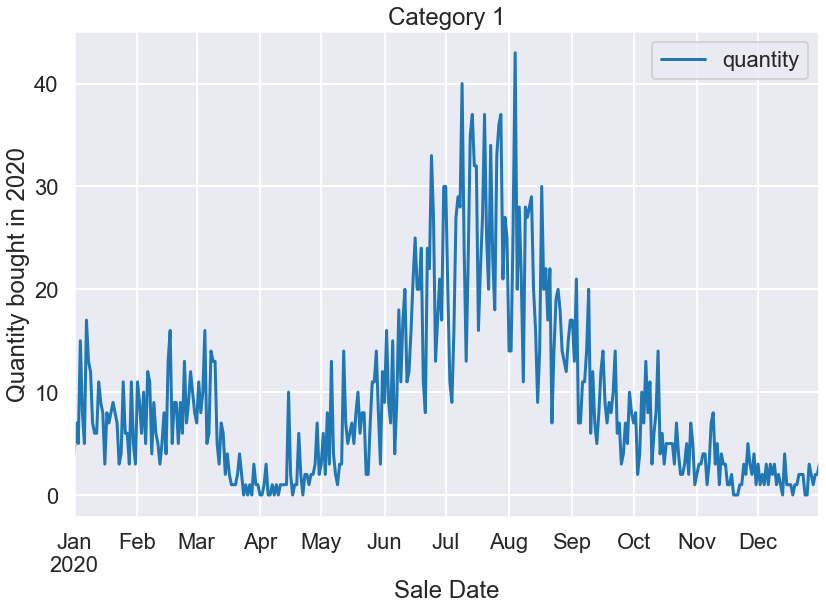

In [35]:
fig, ax = plt.subplots(figsize = (12,9))
boujee_data.plot(ax=ax, legend=True)
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
fig.tight_layout()
plt.savefig('images/cat1_chart.jpeg', format='jpeg');

## Stationarity checks for Boujee category data

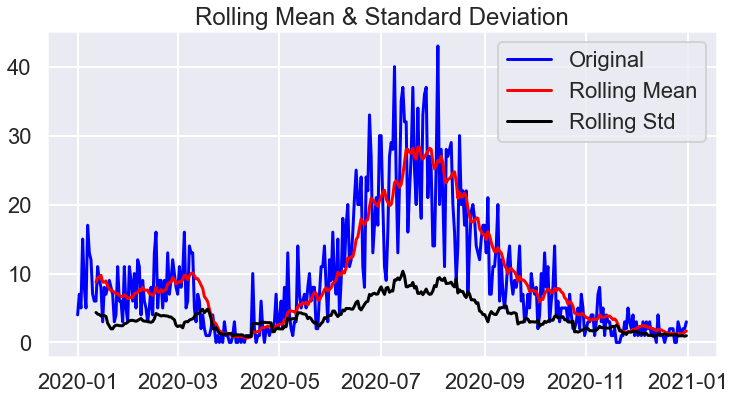

Results of Dickey-Fuller Test: 

Test Statistic                  -1.386494
p-value                          0.588734
#Lags Used                      17.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


In [36]:
stationarity_check(boujee_data)

The time series is not stationary, as the p-value is substantial (0.59 instead of smaller than the typical threshold value 0.05). Let's difference the data.

In [37]:
# Difference your data
boujee_diff = boujee_data.diff()

# Drop the missing values
boujee_diff.dropna(inplace=True)

# Check out the first few rows
boujee_diff.head()

,quantity
sale_date,
2020-01-02,3.0
2020-01-03,-2.0
2020-01-04,10.0
2020-01-05,-7.0
2020-01-06,-3.0


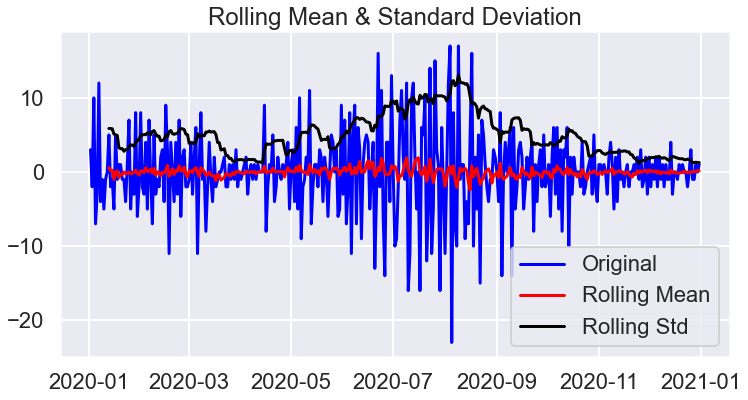

Results of Dickey-Fuller Test: 

Test Statistic                  -3.489370
p-value                          0.008264
#Lags Used                      17.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


In [38]:
stationarity_check(boujee_diff)

The p-value of the Dickey-Fuller test <0.05, so this series seems to be stationary according to this test! But let's try to difference this data again.

In [39]:
# Difference your data
boujee_diff_2 = boujee_diff.diff()

# Drop the missing values
boujee_diff_2.dropna(inplace=True)

# Check out the first few rows
boujee_diff_2.head()

,quantity
sale_date,
2020-01-03,-5.0
2020-01-04,12.0
2020-01-05,-17.0
2020-01-06,4.0
2020-01-07,15.0


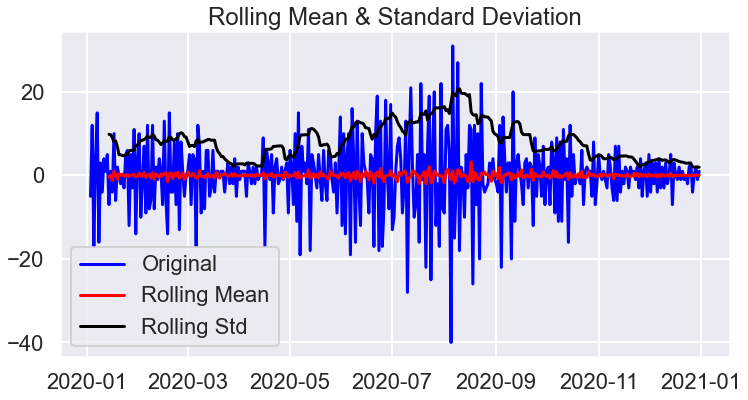

Results of Dickey-Fuller Test: 

Test Statistic                -1.113779e+01
p-value                        3.163258e-20
#Lags Used                     1.600000e+01
Number of Observations Used    3.470000e+02
Critical Value (1%)           -3.449337e+00
Critical Value (5%)           -2.869906e+00
Critical Value (10%)          -2.571227e+00
dtype: float64


In [40]:
stationarity_check(boujee_diff_2)

 The outcome of differencing data twice is better for stationarity. Let's try modeling with d=1,2.

## ACF and PACF for Boujee category data - differenced once

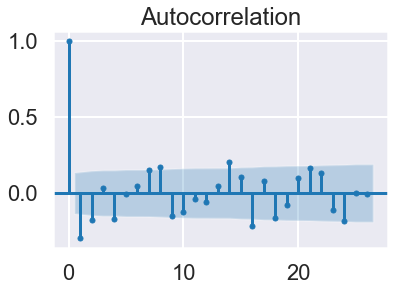

In [41]:
plot_acf(boujee_diff['quantity'], alpha=.01);

Based on ACF graph above, we need to include up to q=5 terms in ARIMA

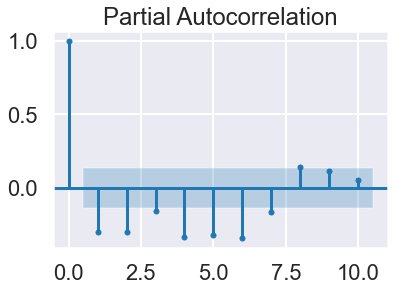

In [42]:
plot_pacf(boujee_diff['quantity'], alpha=.01, lags=10);

Based on PACF graph above, we need to include up to p=9 terms in ARIMA

## ACF and PACF for Boujee category data - differenced twice

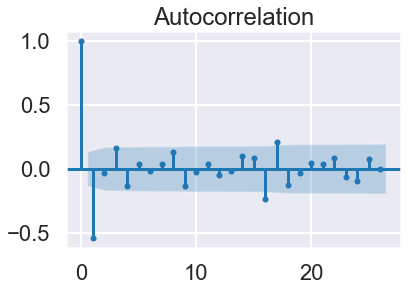

In [43]:
plot_acf(boujee_diff_2['quantity'], alpha=.01);

Based on ACF graph above, we need to include up to q=4 terms in ARIMA

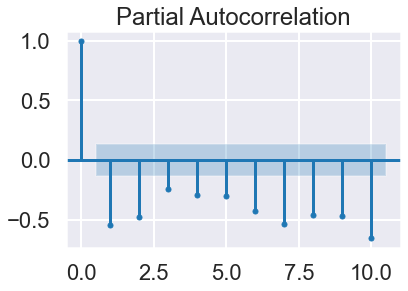

In [44]:
plot_pacf(boujee_diff_2['quantity'], alpha=.01, lags=10);

Based on PACF graph above, we need to include up to p=10 terms in ARIMA

## ARIMA model

### Train test split the data

In [45]:
boujee_data_train = boujee_data[:round(len(boujee_data) * 0.8)]
boujee_data_test = boujee_data[round(len(boujee_data) * 0.8):]
boujee_data_test.shape

(73, 1)

### Grid search for hyperparameters with ARIMA

In [47]:
orderlist = []
aiclist = []
rmselist = []
badlist = []
for p in tqdm(range(0,10)):
    for d in range(1,3):
        for q in range(0,6):
            try:
                ordernow = (p,d,q)
                arimax_now = ARIMA(boujee_data_train, order=ordernow).fit(disp=0)
                rmselist.append(np.sqrt(mean_squared_error(boujee_data_test, arimax_now.forecast(73)[0])))
                orderlist.append(ordernow)
                aiclist.append(arimax_now.aic)
            except:
                badlist.append(ordernow)
                continue

  0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
badlist

[(1, 1, 2),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 4),
 (1, 2, 5),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 2, 5),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (3, 2, 5),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4),
 (4, 2, 5),
 (5, 2, 1),
 (5, 2, 2),
 (5, 2, 4),
 (5, 2, 5),
 (6, 2, 2),
 (6, 2, 5),
 (7, 2, 4),
 (7, 2, 5),
 (8, 1, 2),
 (8, 1, 3),
 (8, 1, 4),
 (8, 1, 5),
 (9, 1, 4),
 (9, 1, 5)]

In [49]:
df_arima = pd.DataFrame()
df_arima['order'], df_arima['aic'], df_arima['rmse'] = orderlist, aiclist, rmselist

In [50]:
df_arima.sort_values('aic').head(15)

,order,aic,rmse
45,"(5, 1, 5)",1707.618281,3.441506
53,"(6, 1, 5)",1707.751629,3.550459
36,"(4, 1, 3)",1707.892445,3.661466
38,"(4, 1, 5)",1707.968033,4.241643
37,"(4, 1, 4)",1709.066463,3.854955
43,"(5, 1, 3)",1709.378960,3.812921
31,"(3, 1, 5)",1709.489017,3.775088
24,"(2, 1, 5)",1709.829602,3.673327
63,"(7, 1, 5)",1709.848063,3.794603
50,"(6, 1, 2)",1710.105143,3.553733


### ARIMA with order=(4,1,5)
This is the best model according to the search above. Some models with better AIC/RMSE scores were rejected due to p-values of variables  > 0.05 in ARIMA Model Results below

In [51]:
model_boujee=ARIMA(boujee_data_train, order=(4,1,5))
model_boujee_fit = model_boujee.fit(disp=0)
print(model_boujee_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.quantity   No. Observations:                  292
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -842.984
Method:                       css-mle   S.D. of innovations              4.246
Date:                Wed, 24 Mar 2021   AIC                           1707.968
Time:                        19:31:40   BIC                           1748.412
Sample:                    01-02-2020   HQIC                          1724.168
                         - 10-19-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0043      0.058     -0.074      0.941      -0.118       0.110
ar.L1.D.quantity    -0.5064      0.028    -17.841      0.000      -0.562      -0.451
ar.L2.D.quantity     0.3139 

<AxesSubplot:xlabel='sale_date'>

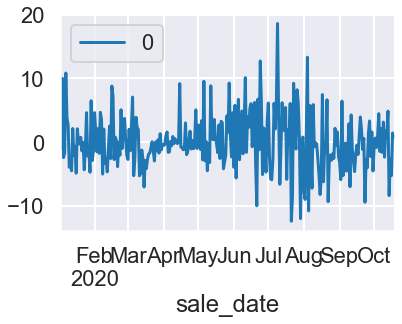

In [52]:
residuals = pd.DataFrame(model_boujee_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

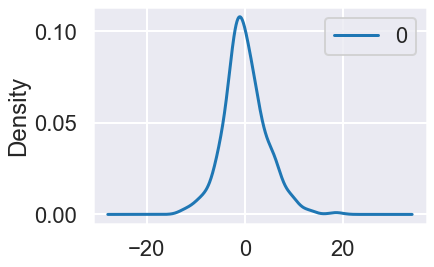

In [53]:
residuals.plot(kind='kde')

In [54]:
model_boujee_fit.forecast(73)[0]

array([5.79862897, 8.53163683, 7.45246974, 8.16859664, 4.53922859,
       4.79110983, 4.04875776, 6.03300107, 7.88322405, 7.77832386,
       7.8725703 , 4.8903783 , 4.82427062, 3.94731237, 6.06782487,
       7.41826242, 7.97501783, 7.61594806, 5.24947165, 4.77910947,
       3.98002877, 5.97004822, 7.10254439, 8.04399761, 7.43040306,
       5.56152143, 4.72318782, 4.07509213, 5.80193833, 6.89062601,
       8.01048443, 7.31578703, 5.80606745, 4.69236267, 4.185418  ,
       5.61103037, 6.74042198, 7.90690405, 7.25606292, 5.98413442,
       4.69928264, 4.2855194 , 5.42795119, 6.61989855, 7.76308749,
       7.23048332, 6.10742015, 4.74226895, 4.36567181, 5.26864963,
       6.50845723, 7.60182361, 7.22016275, 6.19074112, 4.81263898,
       4.4258652 , 5.13841333, 6.39536569, 7.43799093, 7.21102722,
       6.24761181, 4.89979835, 4.47084172, 5.03599616, 6.27700794,
       7.27966822, 7.19435182, 6.28827712, 4.99420156, 4.50666071,
       4.95698856, 6.15408158, 7.1300252 ])

In [55]:
arima_aic = model_boujee_fit.aic
arima_rmse = np.sqrt(mean_squared_error(boujee_data_test, model_boujee_fit.forecast(73)[0]))
print('AIC:', arima_aic)
print('RMSE:', arima_rmse)

AIC: 1707.9680328188786
RMSE: 4.241642913750046


In [56]:
dates_test = pd.date_range(start='2020-10-20', end='2020-12-31')

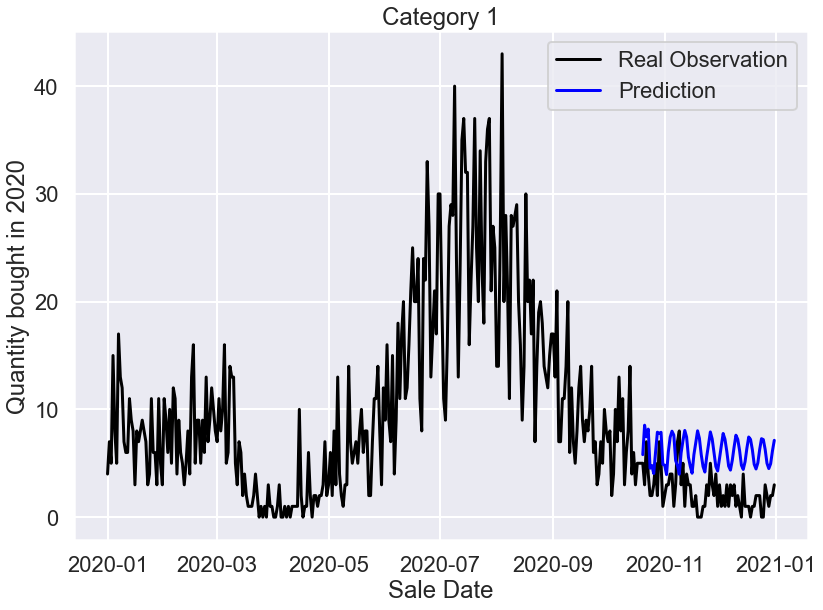

In [57]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(boujee_data, color='black')
ax.plot(dates_test, model_boujee_fit.forecast(73)[0], color='blue')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
plt.legend(('Real Observation', 'Prediction'))
fig.tight_layout()
plt.savefig('images/cat1_ARIMA_4_1_5.jpeg', format='jpeg');

In [58]:
# reset train and test datasets used in ARIMA, so they don't take computing power
boujee_data_train = None
boujee_data_test = None

## FB Prophet model

In [59]:
# let's calculate the maximum amount in any category bought in one day. Plus 25 as a buffer. We'll need this 
# later to establish cap and floor in logistic Prophet
max_cap = combined.groupby(['main_tag', 'sale_date'])['quantity'].sum().max() + 25
max_cap

100

### Rename the columns

In [60]:
boujee_data.reset_index(inplace=True)

In [61]:
# Prophet needs the date column to be named 'ds' and the target column to be named 'y' for it to run
boujee_proph = boujee_data.rename(columns={'sale_date': 'ds',
                                         'quantity': 'y'})
boujee_proph.tail()

,ds,y
361,2020-12-27,2.0
362,2020-12-28,1.0
363,2020-12-29,2.0
364,2020-12-30,2.0
365,2020-12-31,3.0


In [62]:
# We need to specify a carrying capacity in order to utilize a saturating minimum later
boujee_proph['cap'] = max_cap

# Let's specify a saturating minimum, so our model doesn't predict below it.
boujee_proph['floor'] = 0

### Train test split the data

In [64]:
boujee_proph_train = boujee_proph[:round(len(boujee_data) * 0.8)]
boujee_proph_test = boujee_proph[round(len(boujee_data) * 0.8):]
boujee_proph_test.shape

(73, 4)

### Linear Prophet model (monthly)

In [66]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_boujee_proph = proph(interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_boujee_proph.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_boujee_proph.add_country_holidays(country_name='US')

In [67]:
# Fit the model to our train data
model_boujee_proph_fit = model_boujee_proph.fit(boujee_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [68]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_boujee_proph.make_future_dataframe(periods=73, freq='D')

In [70]:
# predict up to 2020/12/31
forecast_boujee_test = model_boujee_proph_fit.predict(test_dates)

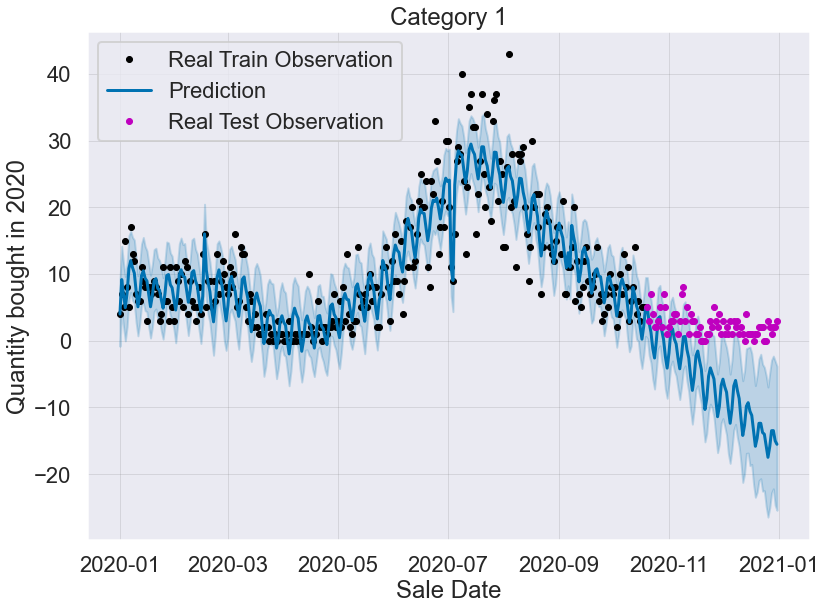

In [72]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_boujee_proph.plot(forecast_boujee_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(boujee_proph_test.ds, boujee_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/lin_prophet_mo.jpeg', format='jpeg');

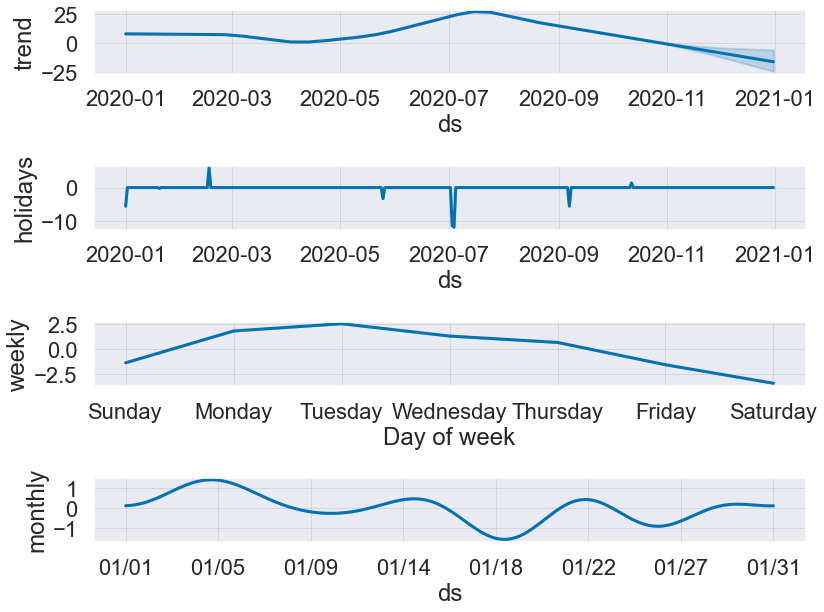

In [73]:
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_boujee_proph.plot_components(forecast_boujee_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/lin_prophet_mo_components.jpeg', format='jpeg');

In [74]:
# set up train and test datasets for calculating MAE and RMSE
y_train = boujee_proph_train['y'].values
y_test = boujee_proph_test['y'].values
y_train_pred = forecast_boujee_test[:-73]['yhat'].values
y_pred = forecast_boujee_test[-73:]['yhat'].values

In [75]:
# calculate train / test MAE and RMSE
lin_proph_train_mae = mean_absolute_error(y_train, y_train_pred)
lin_proph_mae = mean_absolute_error(y_test, y_pred)
print('Monthly Linear Prophet train MAE: {:.2f}'.format(lin_proph_train_mae))
print('Monthly Linear Prophet test MAE: {:.2f}'.format(lin_proph_mae))
print('\n')
lin_proph_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
lin_proph_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Monthly Linear Prophet train RMSE: {:.2f}'.format(lin_proph_train_rmse))
print('Monthly Linear Prophet test RMSE: {:.2f}'.format(lin_proph_rmse))

Monthly Linear Prophet train MAE: 3.12
Monthly Linear Prophet test MAE: 9.04


Monthly Linear Prophet train RMSE: 4.07
Monthly Linear Prophet test RMSE: 10.36


### Logistic Prophet model (monthly)

In [76]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_boujee_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_boujee_proph.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_boujee_proph.add_country_holidays(country_name='US')

In [77]:
# Fit the model to our train data
model_boujee_proph_fit = model_boujee_proph.fit(boujee_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [78]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_boujee_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [80]:
# predict up to 2020/12/31
forecast_boujee_test = model_boujee_proph_fit.predict(test_dates)

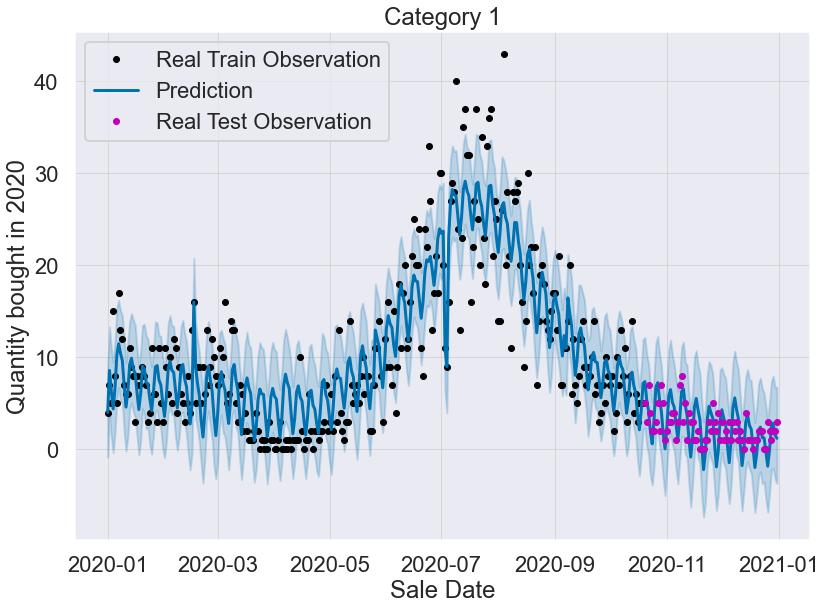

In [82]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_boujee_proph.plot(forecast_boujee_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(boujee_proph_test.ds, boujee_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_mo.jpeg', format='jpeg');

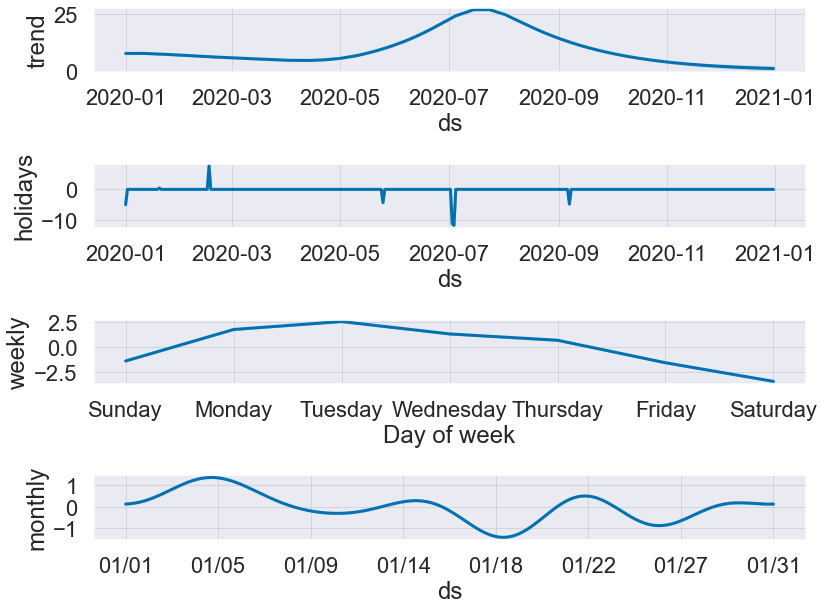

In [83]:
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_boujee_proph.plot_components(forecast_boujee_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_mo_components.jpeg', format='jpeg');

In [84]:
# set up train and test datasets for calculating MAE and RMSE
y_train = boujee_proph_train['y'].values
y_test = boujee_proph_test['y'].values
y_train_pred = forecast_boujee_test[:-73]['yhat'].values
y_pred = forecast_boujee_test[-73:]['yhat'].values

In [85]:
# calculate train / test MAE and RMSE
log_proph_train_mae = mean_absolute_error(y_train, y_train_pred)
log_proph_mae = mean_absolute_error(y_test, y_pred)
print('Monthly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae))
print('Monthly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae))
print('\n')
log_proph_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Monthly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse))
print('Monthly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse))

Monthly Logistic Prophet train MAE: 3.39
Monthly Logistic Prophet test MAE: 2.01


Monthly Logistic Prophet train RMSE: 4.29
Monthly Logistic Prophet test RMSE: 2.35


In [86]:
# compare RMSE scores between ARIMA, Linear Prophet and Logistic Prophet models
print('ARIMA RMSE: %.3f' % arima_rmse)
print('Linear Prophet RMSE: %.3f' % lin_proph_rmse)
print('Logistic Prophet RMSE: %.3f' % log_proph_rmse)

ARIMA RMSE: 4.242
Linear Prophet RMSE: 10.365
Logistic Prophet RMSE: 2.345


Logistic Prophet model has the best RMSE score. Let's explore if we can improve RMSE further by creating different variations of the logistic Prophet model.

### Weekly Logistic Prophet model

In [87]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Add holidays as they are either open and sell well or closed during some of them
model_boujee_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_boujee_proph.add_seasonality(name='weekly', period=7, fourier_order=3) # this line could be commented out
model_boujee_proph.add_country_holidays(country_name='US')

In [88]:
# Fit the model to our train data
model_boujee_proph_fit = model_boujee_proph.fit(boujee_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_boujee_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [91]:
# predict up to 2020/12/31
forecast_boujee_test = model_boujee_proph_fit.predict(test_dates)

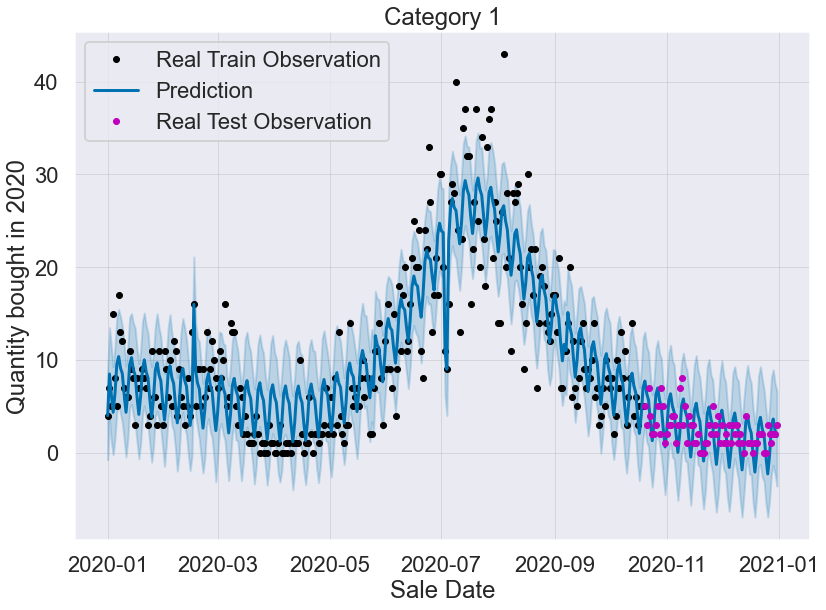

In [93]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_boujee_proph.plot(forecast_boujee_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(boujee_proph_test.ds, boujee_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_wk.jpeg', format='jpeg');

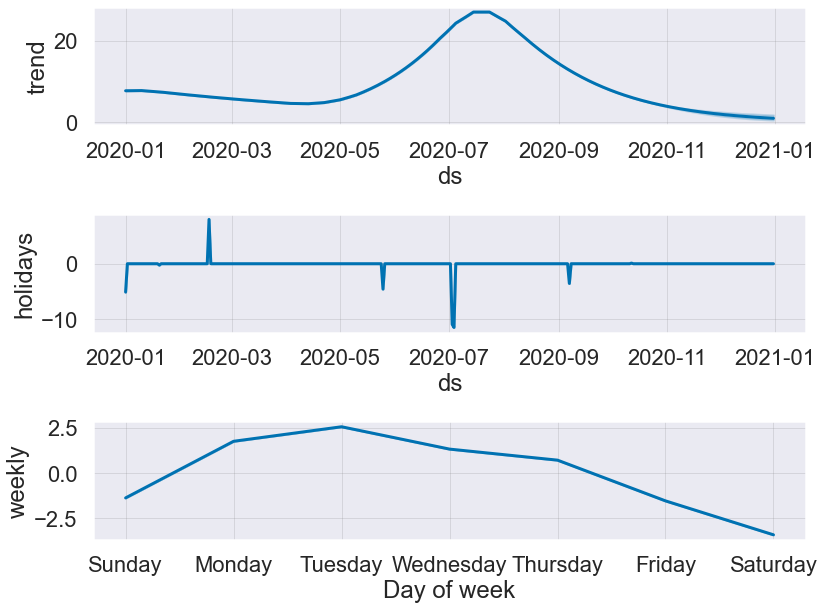

In [94]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_boujee_proph.plot_components(forecast_boujee_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_wk_components.jpeg', format='jpeg');

In [95]:
# set up train and test datasets for calculating MAE and RMSE
y_train = boujee_proph_train['y'].values
y_test = boujee_proph_test['y'].values
y_train_pred = forecast_boujee_test[:-73]['yhat'].values
y_pred = forecast_boujee_test[-73:]['yhat'].values

In [96]:
# calculate train / test MAE and RMSE
log_proph_train_mae_weekly = mean_absolute_error(y_train, y_train_pred)
log_proph_mae_weekly = mean_absolute_error(y_test, y_pred)
print('Weekly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae_weekly))
print('Weekly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae_weekly))
print('\n')
log_proph_train_rmse_weekly = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse_weekly = np.sqrt(mean_squared_error(y_test, y_pred))
print('Weekly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse_weekly))
print('Weekly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse_weekly))

Weekly Logistic Prophet train MAE: 3.43
Weekly Logistic Prophet test MAE: 1.94


Weekly Logistic Prophet train RMSE: 4.34
Weekly Logistic Prophet test RMSE: 2.31


### Quarterly Logistic Prophet model

In [97]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_boujee_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_boujee_proph.add_seasonality(name='quarterly', period=91, fourier_order=7)
model_boujee_proph.add_country_holidays(country_name='US')

In [98]:
# Fit the model to our train data
model_boujee_proph_fit = model_boujee_proph.fit(boujee_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [99]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_boujee_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [101]:
# predict up to 2020/12/31
forecast_boujee_test = model_boujee_proph_fit.predict(test_dates)

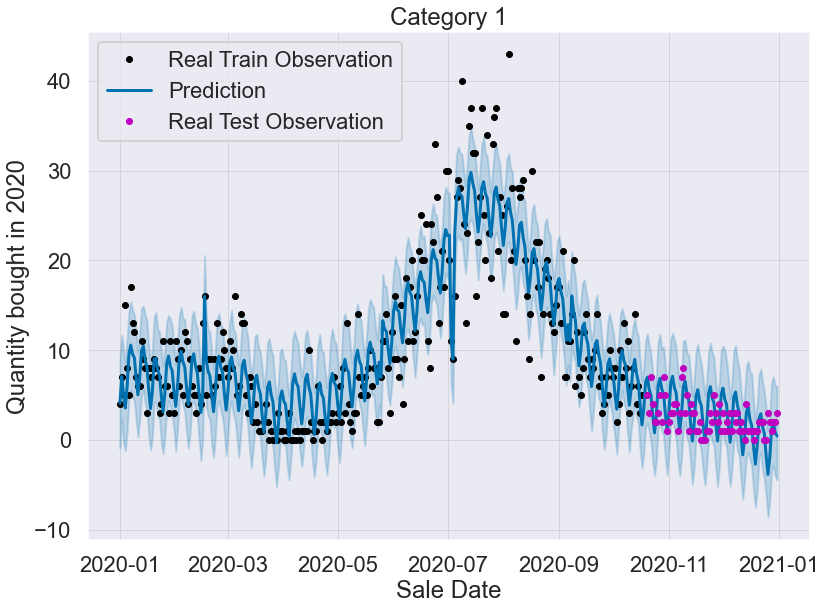

In [103]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_boujee_proph.plot(forecast_boujee_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(boujee_proph_test.ds, boujee_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity bought in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_qtr.jpeg', format='jpeg');

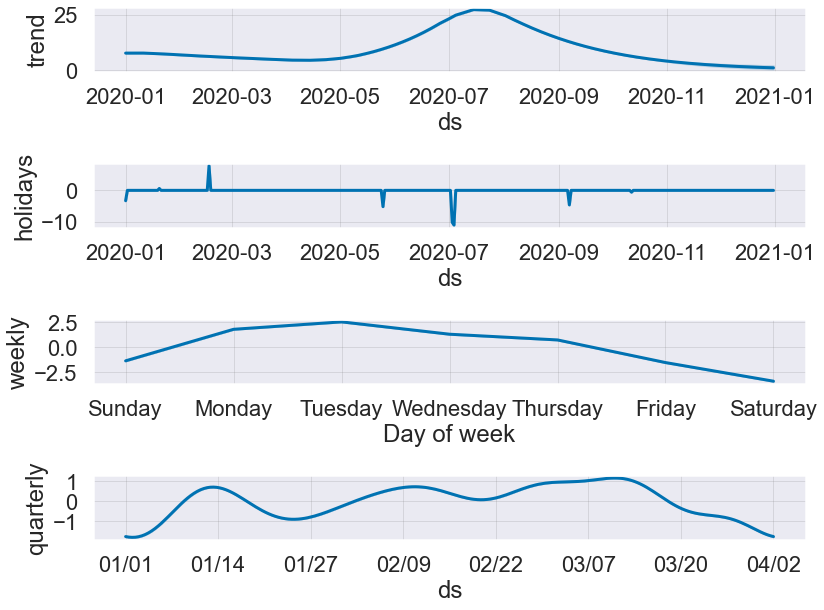

In [104]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_boujee_proph.plot_components(forecast_boujee_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_qtr_components.jpeg', format='jpeg');

In [105]:
# set up train and test datasets for calculating MAE and RMSE
y_train = boujee_proph_train['y'].values
y_test = boujee_proph_test['y'].values
y_train_pred = forecast_boujee_test[:-73]['yhat'].values
y_pred = forecast_boujee_test[-73:]['yhat'].values

In [106]:
# calculate train / test MAE and RMSE
log_proph_train_mae_qtr = mean_absolute_error(y_train, y_train_pred)
log_proph_mae_qtr = mean_absolute_error(y_test, y_pred)
print('Quarterly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae_qtr))
print('Quarterly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae_qtr))
print('\n')
log_proph_train_rmse_qtr = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse_qtr = np.sqrt(mean_squared_error(y_test, y_pred))
print('Quarterly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse_qtr))
print('Quarterly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse_qtr))

Quarterly Logistic Prophet train MAE: 3.32
Quarterly Logistic Prophet test MAE: 2.07


Quarterly Logistic Prophet train RMSE: 4.26
Quarterly Logistic Prophet test RMSE: 2.46


If we had access to data for multiple years, we could have tried Logistic Prophet model with yearly seasonality. 

In [107]:
# compare Prophet train /test MAE and RMSE scores
print('Monthly Logistic Prophet train MAE: %.3f' % log_proph_train_mae)
print('Monthly Logistic Prophet test MAE: %.3f' % log_proph_mae)
print('\n')
print('Weekly Logistic Prophet train MAE: %.3f' % log_proph_train_mae_weekly)
print('Weekly Logistic Prophet test MAE: %.3f' % log_proph_mae_weekly)
print('\n')
print('Quarterly Logistic Prophet train MAE: %.3f' % log_proph_train_mae_qtr)
print('Quarterly Logistic Prophet test MAE: %.3f' % log_proph_mae_qtr)
print('\n')

print('Monthly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse)
print('Monthly Logistic Prophet test RMSE: %.3f' % log_proph_rmse)
print('\n')
print('Weekly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse_weekly)
print('Weekly Logistic Prophet test RMSE: %.3f' % log_proph_rmse_weekly)
print('\n')
print('Quarterly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse_qtr)
print('Quarterly Logistic Prophet test RMSE: %.3f' % log_proph_rmse_qtr)

Monthly Logistic Prophet train MAE: 3.394
Monthly Logistic Prophet test MAE: 2.009


Weekly Logistic Prophet train MAE: 3.430
Weekly Logistic Prophet test MAE: 1.943


Quarterly Logistic Prophet train MAE: 3.315
Quarterly Logistic Prophet test MAE: 2.071


Monthly Logistic Prophet train RMSE: 4.290
Monthly Logistic Prophet test RMSE: 2.345


Weekly Logistic Prophet train RMSE: 4.345
Weekly Logistic Prophet test RMSE: 2.307


Quarterly Logistic Prophet train RMSE: 4.255
Quarterly Logistic Prophet test RMSE: 2.461


Weekly Logistic Prophet model has the best RMSE score. Let's explore if we can improve RMSE by using LSTM model.

In [108]:
# reset datasets used in Prophet, so they don't take computing power
boujee_proph = None
boujee_proph_train = None
boujee_proph_test = None
test_dates = None
forecast_boujee_test = None
y_test = None
y_pred = None

## LSTM model

In [109]:
# function to create LSTM dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back): # was: for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Create LSTM dataset and scale it

In [110]:
# reset index in case index is equal to 'sale_date' column
boujee_data.reset_index(inplace=True)

In [111]:
# drop column 'index' if it exists
boujee_data.drop('index', axis=1, inplace=True)

In [112]:
boujee_lstm = boujee_data
boujee_lstm.set_index('sale_date', inplace=True)

In [114]:
boujee_lstm.head()

,quantity
sale_date,
2020-01-01,4.0
2020-01-02,7.0
2020-01-03,5.0
2020-01-04,15.0
2020-01-05,8.0


In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(boujee_lstm)

### look_back = 1

In [116]:
look_back = 1

In [117]:
train = dataset[:round(len(dataset) * 0.8)]
test = dataset[round(len(dataset) * 0.8) - look_back:]
test.shape

(74, 1)

In [118]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [121]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [124]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [125]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [126]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset), :] = testPredict

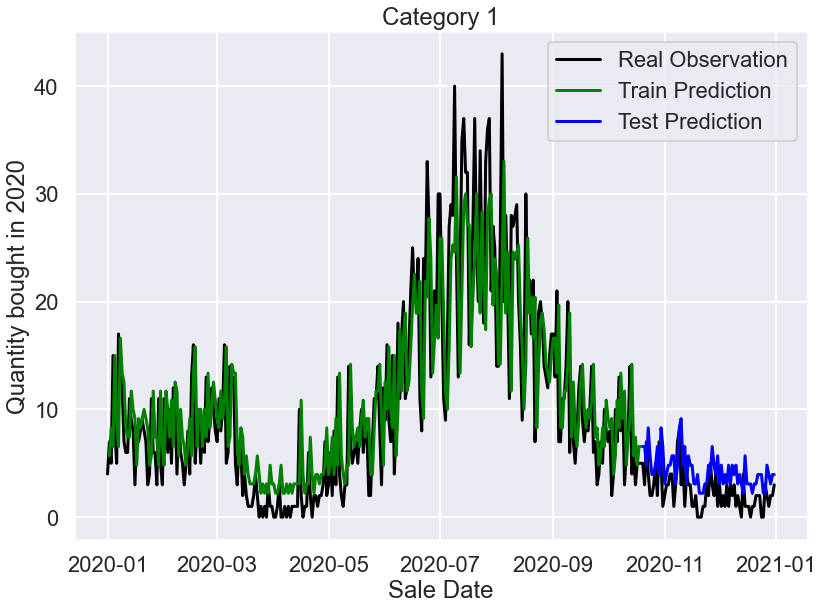

In [129]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(boujee_lstm.index, scaler.inverse_transform(dataset), label='Real Observation', color='black')
ax.plot(boujee_lstm.index, trainPredictPlot, label='Train Prediction', color='green')
ax.plot(boujee_lstm.index, testPredictPlot, label='Test Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity bought in 2020')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_1.jpeg', format='jpeg');

In [130]:
# calculate MAE and RMSE scores
trainScore_mae_1 = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae_1 = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks (look back = 1) train MAE: {:.2f}'.format(trainScore_mae_1))
print('LSTM Networks (look back = 1) test MAE: {:.2f}'.format(testScore_mae_1))
print('\n')
trainScore_1 = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore_1 = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks (look back = 1) train RMSE: {:.2f}'.format(trainScore_1))
print('LSTM Networks (look back = 1) test RMSE: {:.2f}'.format(testScore_1))


LSTM Networks (look back = 1) train MAE: 4.39
LSTM Networks (look back = 1) test MAE: 2.26


LSTM Networks (look back = 1) train RMSE: 5.66
LSTM Networks (look back = 1) test RMSE: 2.70


### look_back = 7

In [131]:
look_back = 7

In [132]:
train = dataset[:round(len(dataset) * 0.8)]
test = dataset[round(len(dataset) * 0.8) - look_back:]
test.shape

(80, 1)

In [133]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [136]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [139]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [140]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [145]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset), :] = testPredict
# was testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

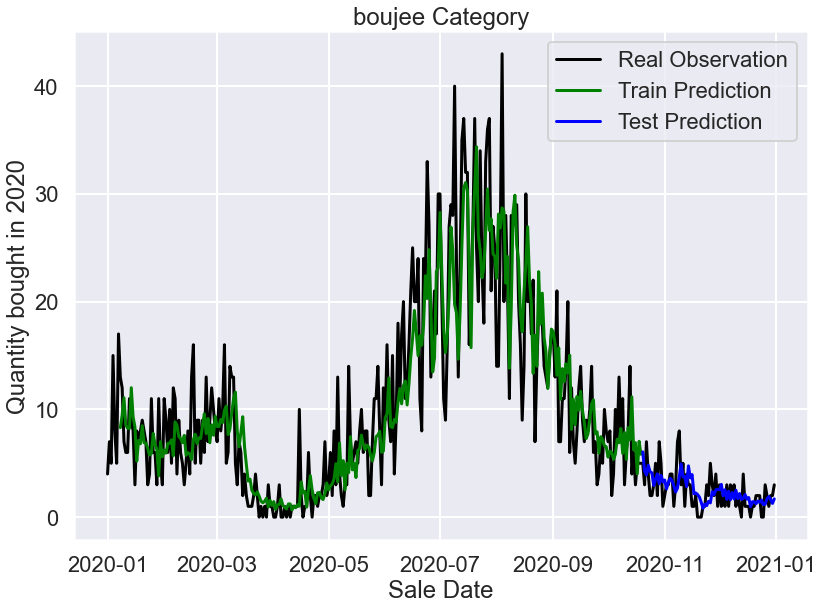

In [148]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(boujee_lstm.index, scaler.inverse_transform(dataset), label='Real Observation', color='black')
ax.plot(boujee_lstm.index, trainPredictPlot, label='Train Prediction', color='green')
ax.plot(boujee_lstm.index, testPredictPlot, label='Test Prediction', color='blue')
plt.title('boujee Category')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity bought in 2020')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_7.jpeg', format='jpeg');

In [149]:
# calculate MAE and RMSE scores
trainScore_mae_7 = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae_7 = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks (look back = 7) train MAE: {:.2f}'.format(trainScore_mae_7))
print('LSTM Networks (look back = 7) test MAE: {:.2f}'.format(testScore_mae_7))
print('\n')
trainScore_7 = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore_7 = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks (look back = 7) train RMSE: {:.2f}'.format(trainScore_7))
print('LSTM Networks (look back = 7) test RMSE: {:.2f}'.format(testScore_7))

LSTM Networks (look back = 7) train MAE: 3.33
LSTM Networks (look back = 7) test MAE: 1.32


LSTM Networks (look back = 7) train RMSE: 4.45
LSTM Networks (look back = 7) test RMSE: 1.64


### look_back = 14

In [155]:
look_back = 14

In [156]:
train = dataset[:round(len(dataset) * 0.8)]
test = dataset[round(len(dataset) * 0.8) - look_back:]
test.shape

(87, 1)

In [157]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [160]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [163]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [164]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [165]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset), :] = testPredict

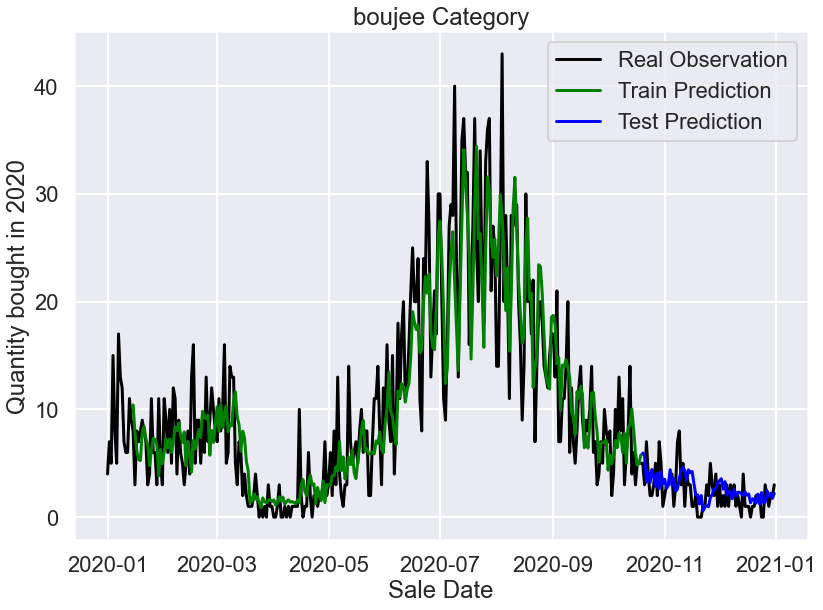

In [168]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(boujee_lstm.index, scaler.inverse_transform(dataset), label='Real Observation', color='black')
ax.plot(boujee_lstm.index, trainPredictPlot, label='Train Prediction', color='green')
ax.plot(boujee_lstm.index, testPredictPlot, label='Test Prediction', color='blue')
plt.title('boujee Category')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity bought in 2020')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_14.jpeg', format='jpeg');

In [169]:
# calculate MAE and RMSE scores
trainScore_mae_14 = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae_14 = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks (look back = 14) train MAE: {:.2f}'.format(trainScore_mae_14))
print('LSTM Networks (look back = 14) test MAE: {:.2f}'.format(testScore_mae_14))
print('\n')
trainScore_14 = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore_14 = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks (look back = 14) train RMSE: {:.2f}'.format(trainScore_14))
print('LSTM Networks (look back = 14) test RMSE: {:.2f}'.format(testScore_14))

LSTM Networks (look back = 14) train MAE: 3.20
LSTM Networks (look back = 14) test MAE: 1.39


LSTM Networks (look back = 14) train RMSE: 4.19
LSTM Networks (look back = 14) test RMSE: 1.75


In [170]:
# compare LSTM train / test MAE and RMSE scores
print('LSTM Networks (look back = 1) train MAE: {:.2f}'.format(trainScore_mae_1))
print('LSTM Networks (look back = 1) test MAE: {:.2f}'.format(testScore_mae_1))
print('\n')
print('LSTM Networks (look back = 7) train MAE: {:.2f}'.format(trainScore_mae_7))
print('LSTM Networks (look back = 7) test MAE: {:.2f}'.format(testScore_mae_7))
print('\n')
print('LSTM Networks (look back = 14) train MAE: {:.2f}'.format(trainScore_mae_14))
print('LSTM Networks (look back = 14) test MAE: {:.2f}'.format(testScore_mae_14))
print('\n')

print('LSTM Networks (look back = 1) train RMSE: {:.2f}'.format(trainScore_1))
print('LSTM Networks (look back = 1) test RMSE: {:.2f}'.format(testScore_1))
print('\n')
print('LSTM Networks (look back = 7) train RMSE: {:.2f}'.format(trainScore_7))
print('LSTM Networks (look back = 7) test RMSE: {:.2f}'.format(testScore_7))
print('\n')
print('LSTM Networks (look back = 14) train RMSE: {:.2f}'.format(trainScore_14))
print('LSTM Networks (look back = 14) test RMSE: {:.2f}'.format(testScore_14))
print('\n')

LSTM Networks (look back = 1) train MAE: 4.39
LSTM Networks (look back = 1) test MAE: 2.26


LSTM Networks (look back = 7) train MAE: 3.33
LSTM Networks (look back = 7) test MAE: 1.32


LSTM Networks (look back = 14) train MAE: 3.20
LSTM Networks (look back = 14) test MAE: 1.39


LSTM Networks (look back = 1) train RMSE: 5.66
LSTM Networks (look back = 1) test RMSE: 2.70


LSTM Networks (look back = 7) train RMSE: 4.45
LSTM Networks (look back = 7) test RMSE: 1.64


LSTM Networks (look back = 14) train RMSE: 4.19
LSTM Networks (look back = 14) test RMSE: 1.75




In [171]:
# reset datasets used in LSTM, so they don't take computing power
boujee_lstm = None
dataset = None
train = None
test = None
trainX = None
trainY = None
testX = None
testY = None
trainPredict = None
testPredict = None
trainPredictPlot = None
testPredictPlot = None

## Evaluation

In [177]:
# create lists of Logistic Prophet train / test RMSE
log_proph_train_rmse_list = [log_proph_train_rmse_weekly, log_proph_train_rmse, log_proph_train_rmse_qtr]
log_proph_test_rmse_list = [log_proph_rmse_weekly, log_proph_rmse, log_proph_rmse_qtr]

In [195]:
# create lists of LSTM train / test RMSE
lstm_train_rmse_list = [trainScore_1, trainScore_7, trainScore_14]
lstm_test_rmse_list = [testScore_1, testScore_7, testScore_14]

In [202]:
# Set styles of visualizations in case they were reset earlier
sns.set_style('darkgrid')
sns.set_context('poster')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


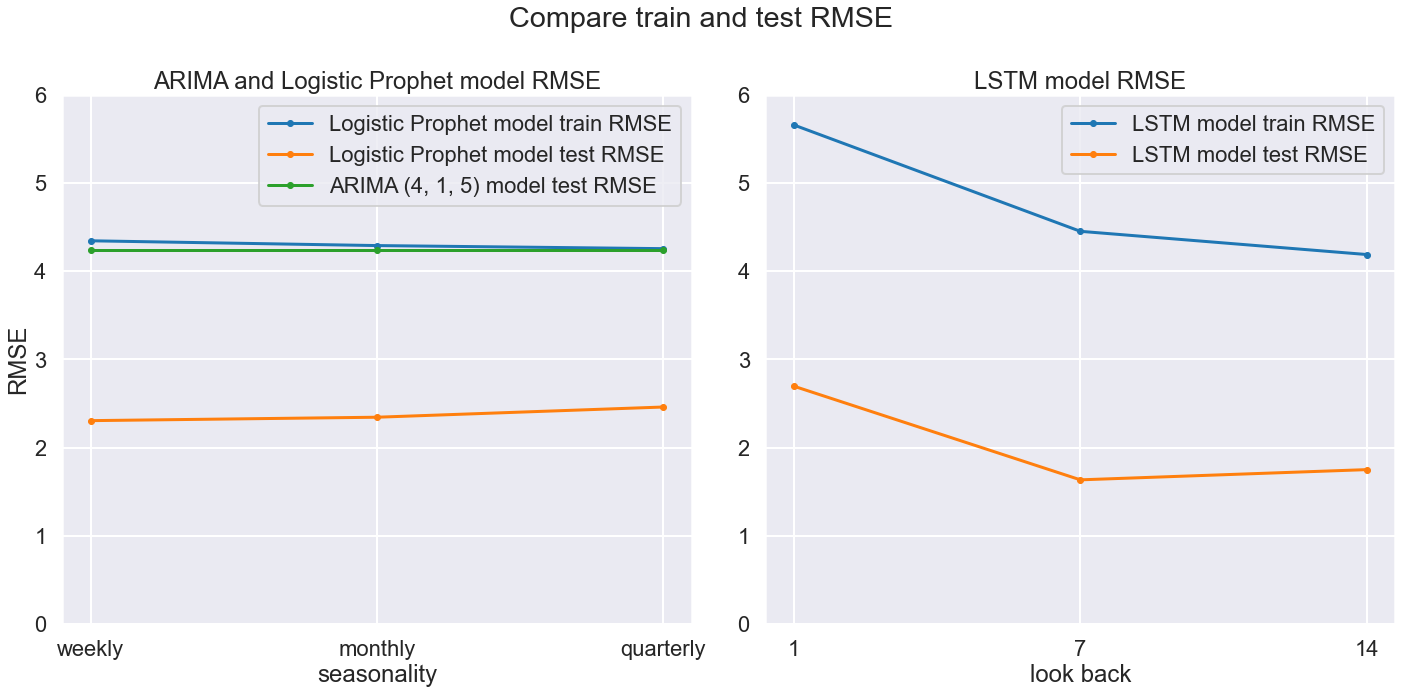

In [208]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(['weekly', 'monthly', 'quarterly'], log_proph_train_rmse_list, marker='.', label='Logistic Prophet model train RMSE')
ax[0].plot(['weekly', 'monthly', 'quarterly'], log_proph_test_rmse_list, marker='.', label='Logistic Prophet model test RMSE')
ax[0].plot(['weekly', 'monthly', 'quarterly'], [arima_rmse, arima_rmse, arima_rmse], marker='.', label='ARIMA (4, 1, 5) model test RMSE')
ax[0].legend()
ax[0].set_title('ARIMA and Logistic Prophet model RMSE')
ax[0].set_xlabel('seasonality')
ax[0].set_ylabel('RMSE')
ax[0].set_ylim([0, 6])

ax[1].plot(['1', '7', '14'], lstm_train_rmse_list, marker='.', label='LSTM model train RMSE')
ax[1].plot(['1', '7', '14'], lstm_test_rmse_list, marker='.', label='LSTM model test RMSE')
ax[1].legend()
ax[1].set_title('LSTM model RMSE')
ax[1].set_xlabel('look back')
ax[1].set_ylabel('')
ax[1].set_ylim([0, 6])

fig.suptitle('Compare train and test RMSE')
fig.tight_layout()
plt.savefig('images/RMSE_comparison.jpeg', format='jpeg');

LSTM model with look_back=14 has the best train/test RMSE results. Let's fit our final model to it.

## Final Model

## Conclusion